# Stack the responses up

In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from umap import UMAP

/mnt/home/kim/venvs/my_environment/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/mnt/home/kim/venvs/my_environment/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/mnt/home/kim/venvs/my_environment/lib/python3.9/site-packages/umap/dist

## Demographics dataset

In [2]:
# get the demographcis dataset
demos = pd.read_csv('~/thesis/data/processed_data/anes_demographics.csv')

In [3]:
demos.set_index('id_case', inplace=True)

In [4]:
demos.index

Index([200015, 200022, 200039, 200046, 200053, 200060, 200084, 200091, 200107,
       200114,
       ...
       535216, 535230, 535254, 535292, 535308, 535315, 535360, 535414, 535421,
       535469],
      dtype='int64', name='id_case', length=8280)

### filter only the YES vote to the president

In [5]:
demos = demos[demos['POST_vote'] == 1]

## 1. dataset and embedding
* data: stacked embeddings
* word-embedding: distilbert
* difference: stack all the responses

In [6]:
# Read the embedding file. Check generating procedure from the 'generate_embedding.ipynb' file. 
emb = pd.read_json("~/thesis/embeddings/response_distilbert_stack.jsonl", orient = 'records', lines = True)

In [7]:
emb

,id_case,stack
0,200015,"[-0.0944291651, 0.11583015320000001, -0.522738..."
1,200022,"[-0.227941528, -0.2221784741, 0.0722830296, -0..."
2,200039,"[-0.31465277080000004, -0.1669896692, -0.14315..."
3,200046,"[-0.44672465320000004, -0.21085768940000002, -..."
4,200053,"[-0.1235457361, -0.0382902212, -0.2772190571, ..."
...,...,...
16511,535360,"[0.08293481920000001, -0.147975415, -0.2894186..."
16512,535414,"[-0.25563645360000004, -0.0924206674, 0.046009..."
16513,535421,"[-0.282428503, -0.0667776763, -0.0506431349000..."
16514,535469,"[0.1071104258, -0.0365130864, -0.0864751041, 0..."


In [8]:
emb = emb[emb['id_case'].isin(demos.index)]

In [9]:
emb

,id_case,stack
1,200022,"[-0.227941528, -0.2221784741, 0.0722830296, -0..."
2,200039,"[-0.31465277080000004, -0.1669896692, -0.14315..."
3,200046,"[-0.44672465320000004, -0.21085768940000002, -..."
4,200053,"[-0.1235457361, -0.0382902212, -0.2772190571, ..."
5,200060,"[-0.1952392161, -0.198322773, -0.2377441674, 0..."
...,...,...
16509,535292,"[0.0800312385, -0.1159780398, -0.0896203369, 0..."
16510,535308,"[-0.0827028602, 0.024626174900000002, -0.22921..."
16511,535360,"[0.08293481920000001, -0.147975415, -0.2894186..."
16512,535414,"[-0.25563645360000004, -0.0924206674, 0.046009..."


In [10]:
# "transform embedding"
from ast import literal_eval
emb['stack'] = emb['stack'].apply(np.array)  # convert list to numpy array
matrix = np.vstack(emb['stack'].values)
matrix.shape

/tmp/ipykernel_1226422/1083339926.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emb['stack'] = emb['stack'].apply(np.array)  # convert list to numpy array


(13426, 768)

In [11]:
X = matrix.copy()

In [12]:
X.shape

(13426, 768)

## Dimensionality reduction

### UMAP

In [13]:
# Step 1: Normalize the data
normalized_embeddings = StandardScaler().fit_transform(X)

In [14]:
# Step 2: Apply UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=0)
umap_embeddings = umap_model.fit_transform(normalized_embeddings)
X = umap_embeddings.copy()

### silhouette score

In [15]:
# Step 3: Use silhouette score to find optimal number of clusters
silhouette_scores = []
for num_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

optimal_num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2

The last line derives from the fact that silhouette score is calculated from the num_cluster 2, so therefore if retrieving index of the lists, the first element's index is 0 but it indicates the value of num_cluster 2, therefore +2 would make it easier to retrieve the value. 


In [16]:
optimal_num_clusters

4

### elbow method

In [17]:
# Use Elbow-analysis as well to find optimal number of clusters
# Elbow analysis
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)

    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

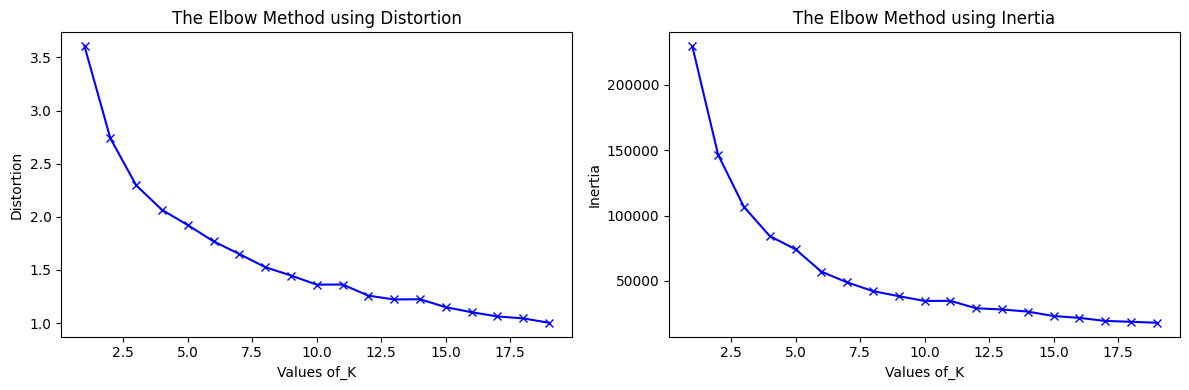

In [18]:
# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # Adjust figsize as needed

# Plot the first plot on ax1
ax1.plot(K, distortions, 'bx-')
ax1.set_xlabel('Values of_K')
ax1.set_ylabel('Distortion')
ax1.set_title('The Elbow Method using Distortion')


# Plot the second plot on ax2
ax2.plot(K, inertias, 'bx-')
ax2.set_xlabel('Values of_K')
ax2.set_ylabel('Inertia')
ax2.set_title('The Elbow Method using Inertia')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

## KMeans clustering

In [31]:
# Step 4: Perform final clustering
final_kmeans = KMeans(n_clusters = 4, random_state=0)
final_cluster_labels = final_kmeans.fit_predict(X)

# Save the result of clustering with random state 0 as a dataframe column
emb['random_0'] = final_cluster_labels  

/tmp/ipykernel_1226422/257776505.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emb['random_0'] = final_cluster_labels


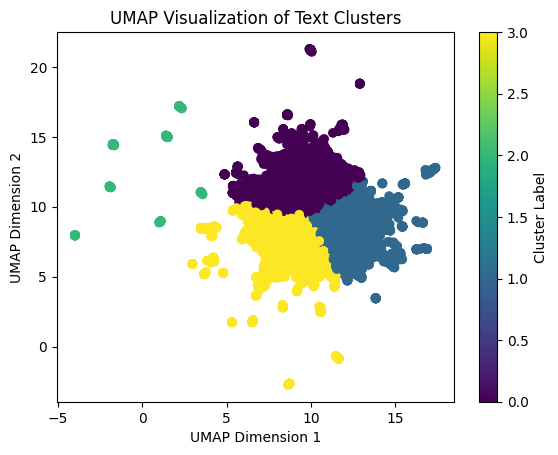

In [32]:
# Visualize clustering depending on different random states.
figures = [] # list to hold different figures. 

fig1, ax1 = plt.subplots()
scatter = ax1.scatter(X[:, 0], X[:, 1], c=final_cluster_labels, cmap='viridis')
ax1.set_xlabel('UMAP Dimension 1')
ax1.set_ylabel('UMAP Dimension 2')
ax1.set_title('UMAP Visualization of Text Clusters')

colorbar = plt.colorbar(scatter, ax=ax1)
colorbar.set_label('Cluster Label')

figures.append(fig1)

In [33]:
# Cluster labels obtained from clustering algorithm

final_cluster_labels # cluster_labels_from_bert
X # contextualized tokens of the input texts.

# Specify the question that is addressed. 
print("\n\"Question 1\"\n")

# Calculate Silhouette Coefficient
silhouette = silhouette_score(X, final_cluster_labels)
print(f"Silhouette Coefficient: {silhouette}")

# Calculate Calinski-Harabasz Index
calinski = calinski_harabasz_score(X, final_cluster_labels)
print(f"Calinski-Harabasz Index: {calinski}")

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(X, final_cluster_labels)
print(f"Davies-Bouldin Index: {davies_bouldin}")


"Question 1"

Silhouette Coefficient: 0.3847624957561493
Calinski-Harabasz Index: 7672.59965465458
Davies-Bouldin Index: 0.8051940457391522


## evaluation metrics: NPMI

In [34]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from itertools import combinations
import gensim
from gensim.utils import simple_preprocess

[nltk_data] Downloading package stopwords to
[nltk_data]     /mnt/home/kim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
# retrieve text documents to check the clustering results with NPMI
data = pd.read_json('~/thesis/data/processed_uscensus/political_mentions_stack.jsonl', orient='records', lines=True)
documents = data['stack'].tolist()

In [36]:
# again remove the stopwords while considering extended version. 

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words = list(sent_to_words(documents))
data_words = remove_stopwords(data_words)

In [37]:
# Group documents by cluster
clustered_docs = [[] for _ in range(optimal_num_clusters)]
for doc, label in zip(data_words, final_cluster_labels):
    clustered_docs[label].append(doc)

In [38]:
# Compute co-occurrence matrix
def compute_cooccurrence_matrix(texts):
    word_counts = Counter(word for text in texts for word in text)
    total_count = sum(word_counts.values())
    word_pairs = Counter()
    for text in texts:
        for i, j in combinations(set(text), 2):
            word_pairs[tuple(sorted([i, j]))] += 1
    return word_pairs, word_counts, total_count

# Compute NPMI
def compute_npmi(word_pairs, word_counts, total_count):
    npmi_matrix = {}
    for (w_i, w_j), cooccur_count in word_pairs.items():
        p_i = word_counts[w_i] / total_count
        p_j = word_counts[w_j] / total_count
        p_ij = cooccur_count / total_count
        if p_ij > 0:
            pmi = np.log(p_ij / (p_i * p_j))
            npmi = pmi / -np.log(p_ij)
            npmi_matrix[(w_i, w_j)] = npmi
    return npmi_matrix

# Calculate average NPMI for each cluster
def average_npmi_for_clusters(clustered_docs):
    cluster_npmis = []
    for docs in clustered_docs:
        if not docs:
            continue
        word_pairs, word_counts, total_count = compute_cooccurrence_matrix(docs)
        npmi_matrix = compute_npmi(word_pairs, word_counts, total_count)
        top_words = list(word_counts.keys())
        npmis = [npmi_matrix.get(tuple(sorted([w_i, w_j])), 0) for w_i, w_j in combinations(top_words, 2)]
        if npmis:
            cluster_npmi = np.mean(npmis)
            cluster_npmis.append(cluster_npmi)
    return np.mean(cluster_npmis) if cluster_npmis else 0

average_npmi = average_npmi_for_clusters(clustered_docs)
print("Average NPMI for KMeans clusters:", average_npmi)

Average NPMI for KMeans clusters: 0.010365692634924544
